# IRM with hyperparameter scan

First, we'll set up hyperparameter scanning to fit a neural net to the bikeshare dataset and minimize the mean squared error. Then, we'll apply the same to IRM.

In [1]:
import pandas as pd
import numpy as np

import torch

from torch import nn, optim, autograd
from torch.nn import functional as F

from ax import optimize

Restrict to one year.

In [33]:
df = pd.read_csv('../../../data/Bike-Sharing-Dataset/hour.csv')
df = df[df.yr == 0]

In [36]:
day_dummies = pd.get_dummies(df['weekday'])
day_dummies.columns = ['sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat']

In [37]:
weather_dummies = pd.get_dummies(df['weathersit'], drop_first=True)
weather_dummies.columns = ['misty', 'rainy', 'snowy']

In [38]:
features = [
    'holiday', 'workingday',
    'sun', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'hr',
    'misty', 'rainy', 'snowy',
    'temp', 'atemp', 'hum', 'windspeed'
]

In [39]:
environment = ['season']

In [40]:
target = ['cnt']

In [41]:
df_ = (
    df
    .merge(weather_dummies, left_index=True, right_index=True)
    .merge(day_dummies, left_index=True, right_index=True)
    [features + environment + target]
)

In [43]:
def construct_env(df):
    return {
        'features': torch.Tensor(
            df.drop(environment + target,
                    axis='columns')
              .to_numpy()
        ),
        'target': torch.Tensor(df['cnt'].to_numpy()).unsqueeze(dim=1)
    }

In [10]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return x

In [11]:
mse = nn.MSELoss(reduction='mean')

In [12]:
def penalty(predictions, targets):
    dummy = torch.tensor(1., requires_grad=True)
    loss = mse(predictions*dummy, targets)
    grad = autograd.grad(loss, [dummy], create_graph=True)[0]
    squared_grad_norm = (grad**2).sum()
    return squared_grad_norm

In [47]:
# since we're treating this as tabular, we should not separate the end months
# of the training sets (at 1500), but rather sample randomly

env_test = construct_env(df_[df_.season == 1]) # winter
env_valid = construct_env(df_[df_.season == 4]) # fall
env_1_train = construct_env(df_[df_.season == 2][:1500]) # spring
env_2_train = construct_env(df_[df_.season == 3][:1500]) # summer
env_1_test = construct_env(df_[df_.season == 2][1500:]) # spring
env_2_test = construct_env(df_[df_.season == 3][1500:]) # summer

In [48]:
pooled_train = {
    'features': torch.cat((env_1_train['features'], env_2_train['features'])),
    'target': torch.cat((env_1_train['target'], env_2_train['target']))
}

pooled_test = {
    'features': torch.cat((env_1_test['features'], env_2_test['features'])),
    'target': torch.cat((env_1_test['target'], env_2_test['target']))
}

In [51]:
N_FEATURES = env_test['features'].shape[1]

In [52]:
def fit_evaluate(hidden_dim, learning_rate, n_iters):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    for iteration in range(n_iters):
        preds = net(pooled_train['features'])
        err = mse(preds, pooled_train['target'])
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return mse(net(pooled_test['features']), pooled_test['target']).item()

In [53]:
def fit_model(hidden_dim, learning_rate, n_iters):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    for iteration in range(n_iters):
        preds = net(pooled_train['features'])
        err = mse(preds, pooled_train['target'])
        
        opt.zero_grad()
        err.backward()
        opt.step()
    
    return net

In [55]:
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {
            "name": "hidden_dim",
            "type": "range",
            "value_type": "int",
            "bounds": [1, 100]
        },
        {
            "name": "learning_rate",
            "type": "range",
            "value_type": "float",
            "bounds": [1e-4, 1e-1]
        },
        {
            "name": "n_iters",
            "type": "range",
            "value_type": "int",
            "bounds": [1, 1e4]
        }
    ],
    evaluation_function = lambda p: fit_evaluate(p["hidden_dim"], p["learning_rate"], p["n_iters"]),
    minimize=True,
    total_trials=100
)

[INFO 02-24 17:19:56] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 02-24 17:19:56] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-24 17:19:56] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-24 17:20:06] ax.service.managed_loop: Running optimization trial 2...
[INFO 02-24 17:20:16] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-24 17:20:17] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-24 17:20:20] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-24 17:20:20] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-24 17:20:26] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-24 17:20:43] ax.service.managed_loop: Running optimization 

In [56]:
best_parameters

{'hidden_dim': 98, 'learning_rate': 0.04110141957554568, 'n_iters': 2288}

In [57]:
best_net = fit_model(best_parameters["hidden_dim"], best_parameters["learning_rate"], best_parameters["n_iters"])

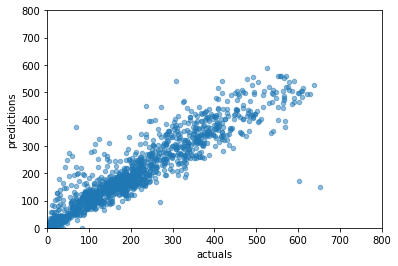

In [61]:
(
    pd.DataFrame({
        "predictions": best_net(pooled_test["features"]).squeeze().tolist(),
        "actuals": pooled_test["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

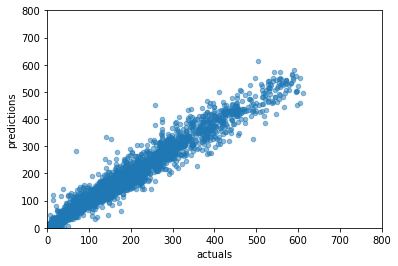

In [62]:
(
    pd.DataFrame({
        "predictions": best_net(pooled_train["features"]).squeeze().tolist(),
        "actuals": pooled_train["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

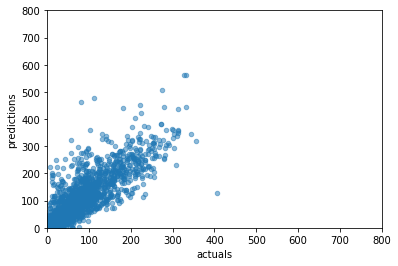

In [63]:
(
    pd.DataFrame({
        "predictions": best_net(env_test["features"]).squeeze().tolist(),
        "actuals": env_test["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

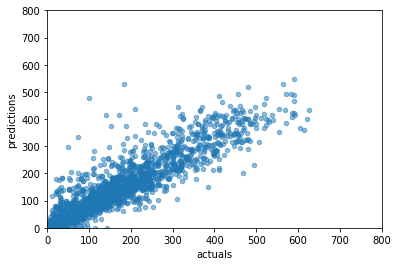

In [66]:
(
    pd.DataFrame({
        "predictions": best_net(env_valid["features"]).squeeze().tolist(),
        "actuals": env_valid["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

In [67]:
mse(best_net(env_test["features"]), env_test["target"]).item()

2789.7353515625

## Once more, with IRM

In [68]:
def fit_evaluate_irm(hidden_dim, learning_rate, n_iters, n_wait, scale):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    env1 = env_1_train.copy()
    env2 = env_2_train.copy()
    
    for iteration in range(n_iters):
        for env in [env1, env2]:
            preds = net(env["features"])
            env['error'] = mse(preds, env["target"])
            env['penalty'] = penalty(preds, env["target"])
        
        train_error = torch.stack([env1['error'], env2['error']]).mean()
        train_penalty = torch.stack([env1['penalty'], env2['penalty']]).mean()

        if iteration < n_wait:
            loss = train_error
        else:
            loss = (scale * train_error + train_penalty)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return mse(net(pooled_test['features']), pooled_test['target']).item()

In [70]:
irm_best_parameters, irm_best_values, irm_experiment, irm_model = optimize(
    parameters=[
        {
            "name": "hidden_dim",
            "type": "range",
            "value_type": "int",
            "bounds": [1, 100]
        },
        {
            "name": "learning_rate",
            "type": "range",
            "value_type": "float",
            "bounds": [1e-4, 1e-1]
        },
        {
            "name": "n_iters",
            "type": "range",
            "value_type": "int",
            "bounds": [1, 1e4]
        },
        {
            "name": "n_wait",
            "type": "range",
            "value_type": "int",
            "bounds": [1, 1e4]
        },
        {
            "name": "scale",
            "type": "range",
            "value_type": "float",
            "bounds": [1e-8, 1e-1]
        }
    ],
    evaluation_function = lambda p: fit_evaluate_irm(
        p["hidden_dim"], p["learning_rate"], p["n_iters"], p["n_wait"], p["scale"]
    ),
    minimize=True,
    total_trials=100
)

[INFO 02-24 17:45:30] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 02-24 17:45:30] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-24 17:45:30] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-24 17:45:58] ax.service.managed_loop: Running optimization trial 2...
[INFO 02-24 17:46:34] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-24 17:46:39] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-24 17:47:00] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-24 17:47:34] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-24 17:47:38] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-24 17:47:46] ax.service.managed_loop: Running optimization 

In [72]:
def fit_irm(hidden_dim, learning_rate, n_iters, n_wait, scale):
    net = NN(N_FEATURES, hidden_dim)
    opt = optim.Adam(net.parameters(), learning_rate)

    env1 = env_1_train.copy()
    env2 = env_2_train.copy()
    
    for iteration in range(n_iters):
        for env in [env1, env2]:
            preds = net(env["features"])
            env['error'] = mse(preds, env["target"])
            env['penalty'] = penalty(preds, env["target"])
        
        train_error = torch.stack([env1['error'], env2['error']]).mean()
        train_penalty = torch.stack([env1['penalty'], env2['penalty']]).mean()

        if iteration < n_wait:
            loss = train_error
        else:
            loss = (scale * train_error + train_penalty)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return net

In [73]:
irm_best_parameters

{'hidden_dim': 18,
 'learning_rate': 0.0031974618126638234,
 'n_iters': 8758,
 'n_wait': 9970,
 'scale': 0.07580101443300634}

In [74]:
irm_best_values

({'objective': 2568.9899589315282},
 {'objective': {'objective': 60.42593469934463}})

In [75]:
best_irm_net = fit_irm(
    irm_best_parameters["hidden_dim"],
    irm_best_parameters["learning_rate"],
    irm_best_parameters["n_iters"],
    irm_best_parameters["n_wait"],
    irm_best_parameters["scale"]
)

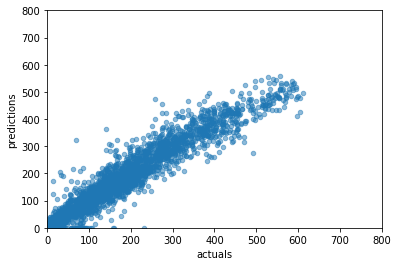

In [77]:
(
    pd.DataFrame({
        "predictions": best_irm_net(pooled_train["features"]).squeeze().tolist(),
        "actuals": pooled_train["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

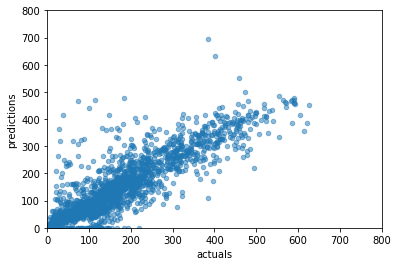

In [78]:
# irm validation set

(
    pd.DataFrame({
        "predictions": best_irm_net(env_valid["features"]).squeeze().tolist(),
        "actuals": env_valid["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

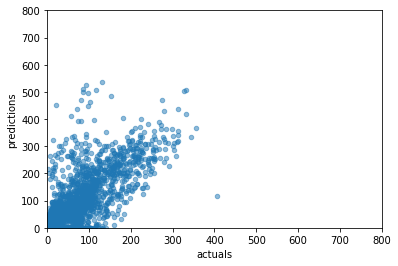

In [82]:
# non-irm validation set

(
    pd.DataFrame({
        "predictions": best_irm_net(env_test["features"]).squeeze().tolist(),
        "actuals": env_test["target"].squeeze().tolist()
    }).plot(
        x="actuals",
        y="predictions",
        kind="scatter",
        alpha=0.5,
        xlim=(0,800),
        ylim=(0,800)
    )
)

In [80]:
np.sqrt(best_values[0]['objective'])

49.703803398273934

In [81]:
np.sqrt(irm_best_values[0]['objective'])

50.68520453674354

### Result

ERM is not making much difference, based on the charts. This makes sense. We're optimizing for test score on data drawn from the same distribution that we're training on. Since the IRM penalty can be weighted (actually, the non-IRM penalty has the inverse weight, for simplicity), the optimization process could easily learn to ignore the IRM component to maximize performance. We should try again, but use one of the held out environments for setting hyperparameters.